In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/signapoop/Desktop/fyp-graph-clustering'

In [2]:
import pandas as pd
import numpy as np
import pickle

In [3]:
parent_dir = os.path.abspath('..')
test_file = '/data/sentences/polarity_emb.pkl'
with open(parent_dir+test_file, 'rb') as f:
    [text, X_emb] = pickle.load(f)

In [4]:
X_emb.shape

(10662, 512)

In [5]:
pos_labels = [1] * 5331
neg_labels = [0] * 5331
all_labels = pos_labels + neg_labels

In [6]:
X = X_emb
y = all_labels

In [7]:
from random import shuffle
random_indices = list(range(len(all_labels)))
shuffle(random_indices)

In [8]:
X = X[random_indices]
y = [y[i] for i in random_indices]

In [9]:
text = [text[i] for i in random_indices]

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42)

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [13]:
y_pred = clf.predict(X_test)

In [14]:
acc = accuracy_score(y_test, y_pred)
acc

0.6935332708528584

In [15]:
from sklearn.manifold import TSNE
X_emb = TSNE(n_components=2, n_iter=3000, verbose=True).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10662 samples in 0.272s...
[t-SNE] Computed neighbors for 10662 samples in 103.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10662
[t-SNE] Computed conditional probabilities for sample 2000 / 10662
[t-SNE] Computed conditional probabilities for sample 3000 / 10662
[t-SNE] Computed conditional probabilities for sample 4000 / 10662
[t-SNE] Computed conditional probabilities for sample 5000 / 10662
[t-SNE] Computed conditional probabilities for sample 6000 / 10662
[t-SNE] Computed conditional probabilities for sample 7000 / 10662
[t-SNE] Computed conditional probabilities for sample 8000 / 10662
[t-SNE] Computed conditional probabilities for sample 9000 / 10662
[t-SNE] Computed conditional probabilities for sample 10000 / 10662
[t-SNE] Computed conditional probabilities for sample 10662 / 10662
[t-SNE] Mean sigma: 0.205034
[t-SNE] KL divergence after 250 iterations with early exaggeration: 94.915527
[t-SNE] K

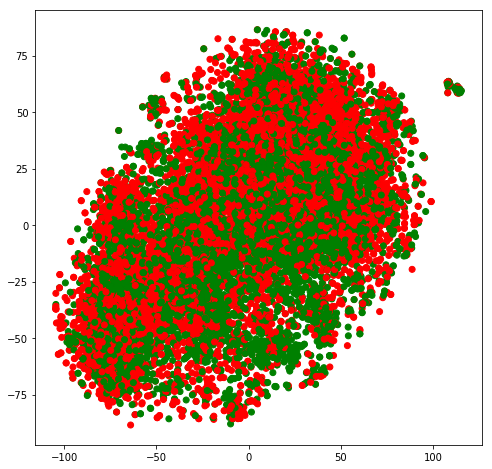

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

colors = ['red','green']
fig = plt.figure(figsize=(8,8))
plt.scatter(X_emb[:,0], X_emb[:,1], c=y, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [17]:
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 94.928482
# [t-SNE] KL divergence after 300 iterations: 4.201113

## Task-specific fine-tuning of embeddings

In [18]:
import torch.nn as nn


class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        #self.fc2 = nn.Linear(300, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        #out = self.fc3(out)
        return out

In [19]:
import torch

inputs = torch.from_numpy(X_train)
targets = torch.from_numpy(np.array(y_train))

In [20]:
model = LogisticRegression(512, 2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    train_loss = loss.data[0]
    _, predicted = torch.max(outputs.data, 1)
    total = targets.size(0)
    correct = predicted.eq(targets.data).cpu().sum()
    
    if epoch % 100 == 0:
        print("Epoch {}, Loss {:.3f}, Acc {}/{}".format(epoch, train_loss, correct, total))

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


Epoch 0, Loss 0.691, Acc 5433/9595
Epoch 100, Loss 0.530, Acc 7066/9595
Epoch 200, Loss 0.508, Acc 7219/9595
Epoch 300, Loss 0.503, Acc 7241/9595
Epoch 400, Loss 0.499, Acc 7275/9595
Epoch 500, Loss 0.495, Acc 7304/9595
Epoch 600, Loss 0.492, Acc 7321/9595
Epoch 700, Loss 0.490, Acc 7334/9595
Epoch 800, Loss 0.487, Acc 7338/9595
Epoch 900, Loss 0.485, Acc 7343/9595


In [21]:
test_inputs = torch.from_numpy(X_test)
y_pred = model(test_inputs)
_, y_pred = torch.max(y_pred.data, 1)

In [22]:
acc = accuracy_score(y_test, y_pred.numpy())
acc

0.7582005623242737

In [23]:
# Use the model object to select the desired layer
layer = model._modules.get('fc1')

In [24]:
# Define a function that will copy the output of a layer
my_embedding = torch.zeros([X.shape[0], 50]) 

def copy_data(m, i, o):
    my_embedding.copy_(o.data)
    
# Attach that function to our selected layer
h = layer.register_forward_hook(copy_data)

In [25]:
test_inputs = torch.from_numpy(X)
y_pred = model(test_inputs)

In [30]:
X_emb = my_embedding.numpy()
from sklearn.manifold import TSNE
X_emb = TSNE(n_components=2, n_iter=2000, verbose=True, perplexity=30).fit_transform(X_emb)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10662 samples in 0.017s...
[t-SNE] Computed neighbors for 10662 samples in 7.812s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10662
[t-SNE] Computed conditional probabilities for sample 2000 / 10662
[t-SNE] Computed conditional probabilities for sample 3000 / 10662
[t-SNE] Computed conditional probabilities for sample 4000 / 10662
[t-SNE] Computed conditional probabilities for sample 5000 / 10662
[t-SNE] Computed conditional probabilities for sample 6000 / 10662
[t-SNE] Computed conditional probabilities for sample 7000 / 10662
[t-SNE] Computed conditional probabilities for sample 8000 / 10662
[t-SNE] Computed conditional probabilities for sample 9000 / 10662
[t-SNE] Computed conditional probabilities for sample 10000 / 10662
[t-SNE] Computed conditional probabilities for sample 10662 / 10662
[t-SNE] Mean sigma: 0.044709
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.698616
[t-SNE] KL 

In [31]:
import bokeh.plotting as bp
from bokeh.plotting import save, show
from bokeh.models import HoverTool
from bokeh.io import output_notebook

colormap = np.array([
    "#ce101a", "#358e05"
])

In [32]:
output_notebook()

Loading BokehJS ...

In [33]:
plot_lda = bp.figure(plot_width=700, plot_height=700,
                     tools="pan, wheel_zoom, box_zoom, reset, hover, previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

data_dict = {'content': text, 
             'x': X_emb[:, 0], 
             'y': X_emb[:, 1],
             'color': colormap[y]}

mySource = bp.ColumnDataSource(data_dict)

plot_lda.circle(x='x', y='y', color='color', source=mySource)

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "@content"}

# save the plot
show(plot_lda)

In [35]:
my_embedding.shape

torch.Size([10662, 50])